# Alternative approaches to field correlations

*last updated February 28th, 2026 by Kevin Anchukaitis to improve time handling and apply_ufunc efficiency and clarify Markdown desscriptions*

`xarray.corr` provides an easy way to do field correlations, but does not return significance levels (p-values) by itself.  For doing field signficance, the absense of pointwise p-values is both annoying and inconvenient.  Alternative approachs to field correlations are shown here using the SOI and 700mb geopotential height again.

Load our packages:

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Cartopy gives a lot of warnings when downloading map data, which we'll suppress
import warnings
warnings.filterwarnings("ignore") 

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# import cartopy 
import cartopy # base Cartopy
import cartopy.crs as ccrs # shortcut to the coordinate reference system
import cartopy.feature as cfeature # add map features


Get the SOI data and prepare it for correlation analysis in xarray, including resetting the monthly time step for datetime:

In [2]:
soi_ds = xr.open_dataset("soi.nc", decode_times=False)

# Parse the starting year and directly from the units attribute string to avoid hardcoding it below
units = soi_ds["time"].attrs["units"]
starting_date = units.split("since")[1].strip()

# create new time coordinate from 'months since'
new_time = pd.date_range(start=starting_date, periods=len(soi_ds["time"]), freq='MS')

# replace the 'month since' time coordinate and extract to DataArray
soi = soi_ds["SOI"].assign_coords(time=new_time)

# create 3 months rolling means, excluding non-existent months
soi_ = soi.rolling(time=3, min_periods=3).mean()

# Select February to get the 3-month rolling average ending in February (i.e. DJF) and we drop the NaN value
djf_soi = soi_[soi_.time.dt.month == 2].dropna(dim='time')


Get the 700mb geopotential height and prepare it for correlation analysis with xarray

In [3]:
hgt = xr.open_dataset("hgt.700mb.mon.mean.nc")["hgt"]

# min_periods=3 to match the SOI treatment above — require all 3 months to be present
hgt_ = hgt.rolling(time=3, min_periods=3).mean()

# Select February to get DJF averages
djf_hgt = hgt_[hgt_.time.dt.month == 2]
djf_hgt = djf_hgt.squeeze(drop=True)  # squeeze out and drop the singleton 'level' dimension


Put both SOI and 700mb height on the same time span - we could ask any individual analysis to handle this, but we can also align these now:

In [4]:
djf_hgt, djf_soi = xr.align(djf_hgt,djf_soi,join="inner") # hgt and sst now have the same time dimension for the remainder of the notebook


### Method 1 - Use `xr.corr` for the Pearson coefficients and then calculate the p-value by hand

Believe it or not, I've found that one very fast way to do this is just to calculate the p-values 'by hand' (e.g. just do the math).  [This Stack Overflow](https://stackoverflow.com/questions/64682256/how-to-calculate-a-correlation-with-p-values-most-performant-in-python) is useful, or you can look in any statistics textbook:

In [5]:
fieldCorrelation = xr.corr(djf_soi,djf_hgt, dim="time")

# calculate the p-values directly using r values and the t-distribution 
t = -abs(fieldCorrelation.values)*np.sqrt((len(djf_soi.time)-2)/(1-np.square(fieldCorrelation.values))) # t score
pvalue = sp.stats.t.cdf(t, len(djf_soi.time) - 2) * 2 # we multiply by 2 for a two-sided test
sig = xr.DataArray(data=pvalue,dims=["lat","lon"],coords=[fieldCorrelation.lat, fieldCorrelation.lon]) # this adds these values to the DataArray with the correct coordinate! 


For plotting, we can use Matplotlib's `scatter` to plot the areas of significance:

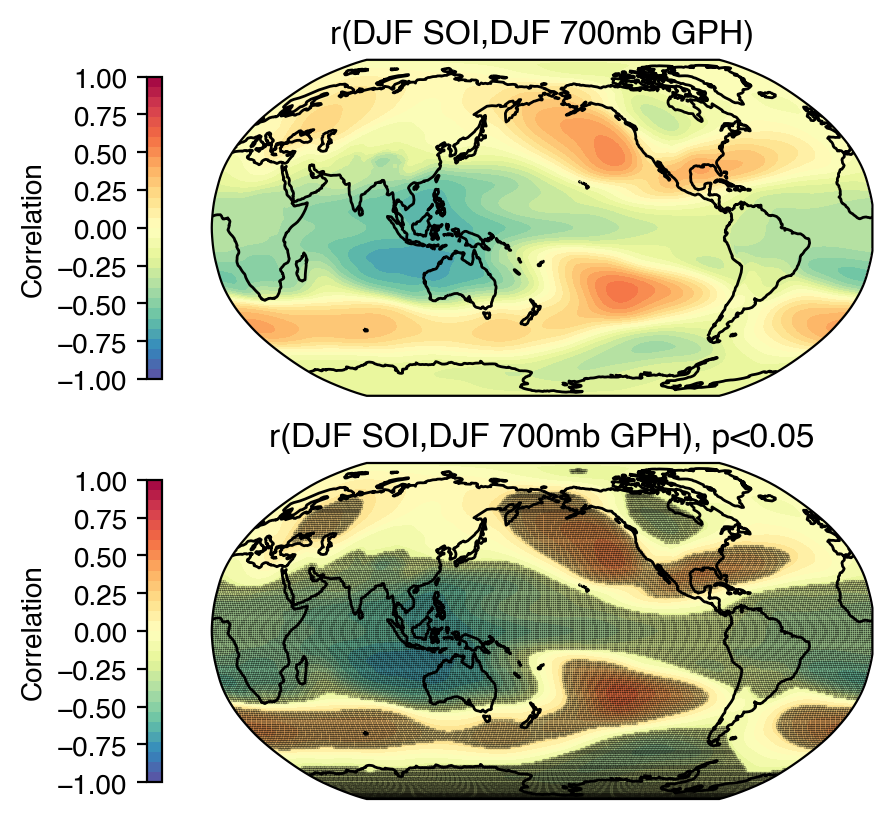

In [6]:
# defines areas with sigificant coefficients
sig_area1   = np.where(sig < 0.05) # hey, this is a tuple!  You could also ask for the opposite and stipple areas that are not significant
lons, lats = np.meshgrid(fieldCorrelation.lon,fieldCorrelation.lat)

# plot the field correlations
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the contour map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(djf_hgt.lon,djf_hgt.lat,fieldCorrelation ,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.set_title('r(DJF SOI,DJF 700mb GPH)', fontsize=12)
cb1 = plt.colorbar(fx1,  orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('Correlation', fontsize=10) 

fx2 = ax2.contourf(djf_hgt.lon,djf_hgt.lat,fieldCorrelation ,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax2.coastlines(color="black")  # we can pass arguments to .coastlines function
ax2.set_title('r(DJF SOI,DJF 700mb GPH), p<0.05', fontsize=12)
cb2 = plt.colorbar(fx2, orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb2.set_label('Correlation', fontsize=10) 

# here are some other marker choices: https://matplotlib.org/stable/api/markers_api.html
ax2.scatter(lons[sig_area1], lats[sig_area1], marker = '.', s = 0.1, c = 'k', alpha = 0.5, transform = ccrs.PlateCarree())


### Method 1.5 - Use the same method above but now make the whole process a single function


In [7]:
def field_correlation(da,db,alpha=0.05,**kwargs):
    # accepts two DataArrays and returns a DataSet with field correlation and associated p-value
    da, db = xr.align(da,db,join="inner") # ensures that the xr.corr command will behave like we want
    
    fieldCorrelation = xr.corr(da,db, dim="time")
  
    # calculate the p-values directly using r values and the t-distribution
    dof = da.sizes['time'] # number of observations
    t = -abs(fieldCorrelation.values)*np.sqrt((dof-2)/(1-np.square(fieldCorrelation.values))) # t-statistic
    pvalue_ = sp.stats.t.cdf(t, dof - 2) * 2 # here multiply by 2 for two-sided test
    pvalue = xr.DataArray(data=pvalue_,dims=["lat","lon"],coords=[fieldCorrelation.lat, fieldCorrelation.lon],name='pvalue') # Make pvalue a DataArray
    fieldCorrelation = fieldCorrelation.to_dataset(name='correlation') # make the correlation coefficients into a DataSet
    fieldCorrelation = xr.merge([fieldCorrelation,pvalue]) # merge the correlation values and p-value into a single DataSet
    return fieldCorrelation

cc = field_correlation(djf_soi,djf_hgt)
cc

<xarray.Dataset> Size: 784kB
Dimensions:      (lat: 181, lon: 360)
Coordinates:
  * lat          (lat) float32 724B -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * lon          (lon) float32 1kB 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
Data variables:
    correlation  (lat, lon) float32 261kB -0.1835 -0.1835 ... -0.1064 -0.1064
    pvalue       (lat, lon) float64 521kB 0.0251 0.0251 0.0251 ... 0.1966 0.1966

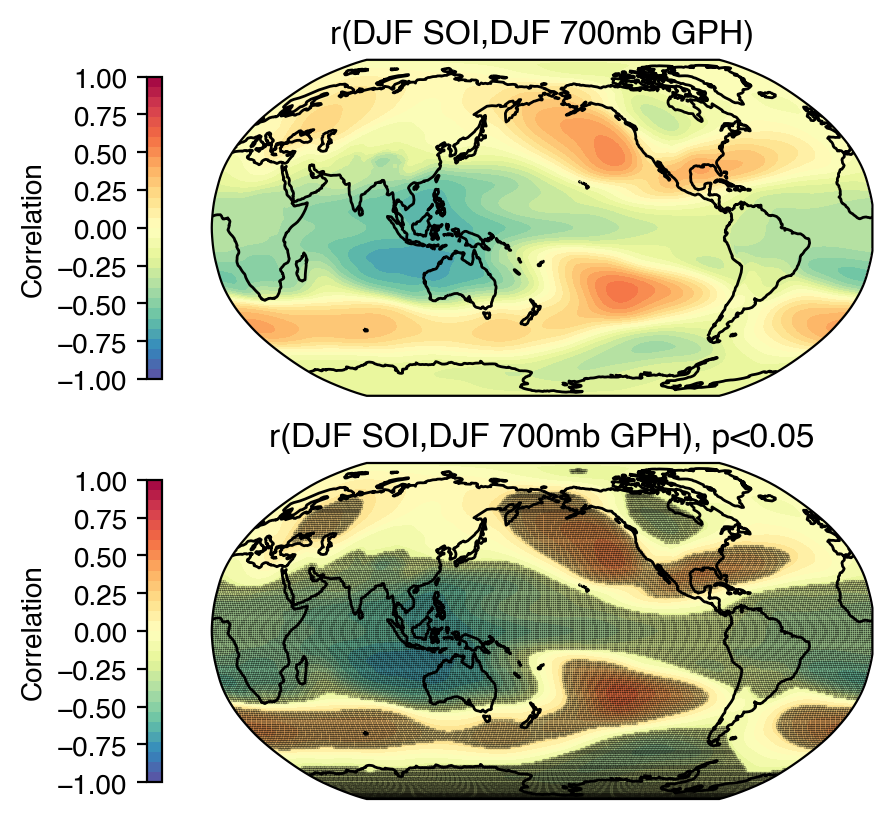

In [8]:
# defines areas with sigificant coefficients
sig_area2   = np.where(cc["pvalue"].values < 0.05) # this is a tuple! 
lons, lats = np.meshgrid(cc.lon, cc.lat) # need this to use scatter for the dotted significance plot

# plot the field correlations
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(cc.lon,cc.lat,cc["correlation"].values,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.set_title('r(DJF SOI,DJF 700mb GPH)', fontsize=12)
cb1 = plt.colorbar(fx1,  orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('Correlation', fontsize=10) 

fx2 = ax2.contourf(cc.lon,cc.lat,cc["correlation"].values,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax2.coastlines(color="black")  # we can pass arguments to .coastlines function
ax2.set_title('r(DJF SOI,DJF 700mb GPH), p<0.05', fontsize=12)
cb2 = plt.colorbar(fx2, orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb2.set_label('Correlation', fontsize=10) 

# here are some other marker choices: https://matplotlib.org/stable/api/markers_api.html
ax2.scatter(lons[sig_area2], lats[sig_area2], marker = '.', s = 0.1, c = 'k', alpha = 0.5, transform = ccrs.PlateCarree())


### Method 2. use xarray's `ufunc`to apply Scipy's `pearsonr` and get correlation and p-values that way

We can use xarray's `apply_ufunc` to use Numpy or Scipy functions on xarray objects (or, perhaps more accurately, we can apply methods that are intended to be used on Numpy arrays, not xarray objects).  [Here](https://tutorial.xarray.dev/advanced/apply_ufunc/simple_numpy_apply_ufunc.html) is an introduction and tutorial for this, but essentially we can (1) write a function that applies e.g. Numpy or Scipy methods to variables, and then (2) use `apply_ufunc` to apply that function to xarray variables while keeping track of the coordinates and dimensions. 

One thing I learned since I first taught this notebook in 2023 is the use of [xarray's `output_core_dims`](https://docs.xarray.dev/en/latest/generated/xarray.apply_ufunc.html). The `input_core_dims` tells the function that both of the input data have a compatible `time` dimension. The optional `output_core_dims` argument tells xarray what dimensions the result of the function should have.  In this case, including it even though it is passed as an 'empty' dimension appears to tell xarray that these are scalar dimensions (e.g. they've lost the time dimension) and allows the 2 outputs from Scipy's Pearson method to be retained as they are (and therefore, remain in the spatial dimensions of the original data, just missing now the `time` dimension). It is quite possible there is still a better way to do this, but this is better that how I did this 3 years ago!

For me, at least, this is actually meaningfully slower than the two solutions above (more than twice as long to complete), but it demonstrates nicely how Numpy and Scipy methods can be used on xarray objects.  [See more here on more complicated aspects of output dimensions from apply_ufunc](https://tutorial.xarray.dev/advanced/apply_ufunc/complex-output-numpy.html#adding-a-new-dimension). 

In [9]:
def pearsonr_both(x, y):
    mask = ~np.isnan(x) & ~np.isnan(y) # for safety, otherwise NaN might be broadcast to the entire output
    r, p = sp.stats.pearsonr(x[mask], y[mask])
    return r, p

pearson_field, pvalue_field = xr.apply_ufunc(
    pearsonr_both, djf_soi, djf_hgt,
    vectorize=True,
    input_core_dims=[['time'], ['time']],
    output_core_dims=[[], []],
    output_dtypes=[float, float],
    join="inner"
)


Once again we can plot as we did above:

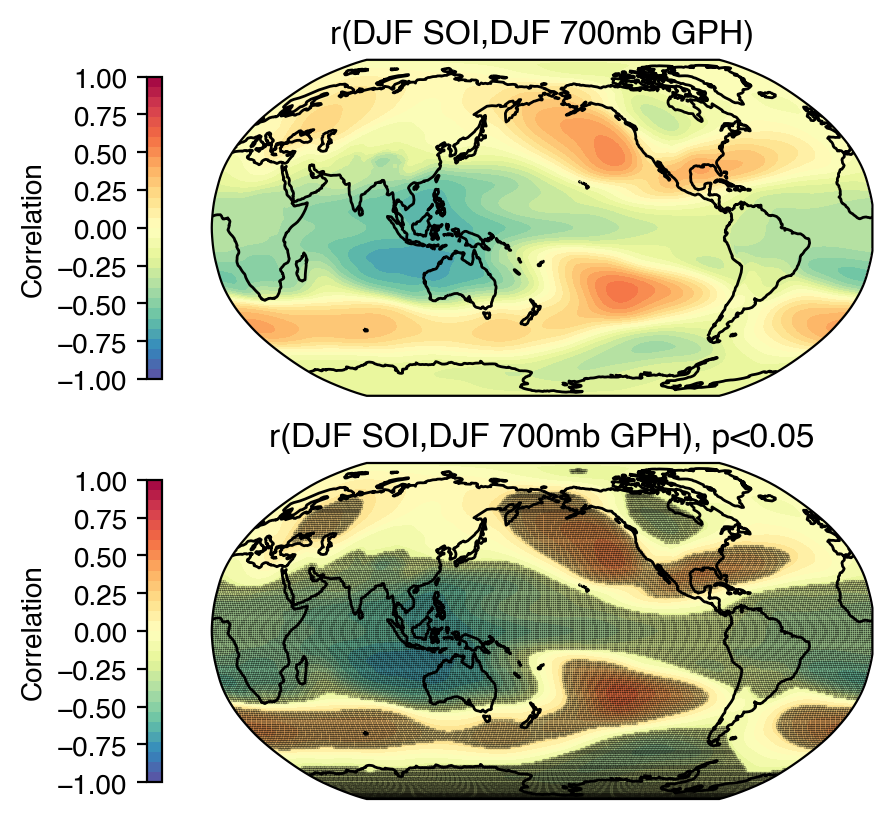

In [10]:
# defines areas with sigificant coefficients
sig_area   = np.where(pvalue_field < 0.05) # this is a tuple! 
lons, lats = np.meshgrid(djf_hgt.lon, djf_hgt.lat)

# plot the field correlations
fig, (ax1,ax2) = plt.subplots(clear=True,nrows=2,ncols=1,subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

# specifying the levels gives us more control on the map
levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(djf_hgt.lon,djf_hgt.lat,pearson_field ,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax1.coastlines(color="black")  # we can pass arguments to .coastlines function
ax1.set_title('r(DJF SOI,DJF 700mb GPH)', fontsize=12)
cb1 = plt.colorbar(fx1,  orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('Correlation', fontsize=10) 

fx2 = ax2.contourf(djf_hgt.lon,djf_hgt.lat,pearson_field ,levels=levels, cmap='Spectral_r',add_colorbar=False, transform=ccrs.PlateCarree())
ax2.coastlines(color="black")  # we can pass arguments to .coastlines function
ax2.set_title('r(DJF SOI,DJF 700mb GPH), p<0.05', fontsize=12)
cb2 = plt.colorbar(fx2, orientation='vertical',location='left',shrink=0.9,pad=0.05,ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb2.set_label('Correlation', fontsize=10) 

ax2.scatter(lons[sig_area], lats[sig_area], marker = '.', s = 0.1, c = 'k', alpha = 0.5, transform = ccrs.PlateCarree())


### Method 3 - Use `xskillscore` for correlation and p-values

The library `xskillscore' -- [documentation here](https://xskillscore.readthedocs.io/en/stable/) -- is an project to bring forecast verification methods to Pandas and xarray.  It has a number of correlation- and distance-based methods for comparing two different datasets (e.g. observations of what happened and a prior forecast, for instance).  The library includes methods for calculating correlation coefficients and the corresponding significance (p) values.  [Here is the documentation for the Pearson correlation](https://xskillscore.readthedocs.io/en/stable/api/xskillscore.pearson_r.html).  You can see that the method takes either xarray.Datasets or xarray.DataArrays and inputs. 

We will need to install the library and then import it first to use it: 

In [11]:
!pip install xskillscore # comment out once completed once
import xskillscore as xs

The syntax is very similar to xarray.  Here we'll call both the `xs.pearson_r` and `xs.pearson_r_p_value` to get the $r$ and $p$ values.  We will also call a third method, `xs.pearson_r_eff_p_value` which accounts for any temporal autocorrelation in the time series (more on that after Spring Break):

In [12]:
# pearson_r_p_value assumes independent time steps (same assumption as Methods 1 and 2)
pearson_field = xs.pearson_r(djf_soi, djf_hgt, dim='time')
pvalue_field  = xs.pearson_r_p_value(djf_soi, djf_hgt, dim='time')

# pearson_r_eff_p_value adjusts for temporal autocorrelation in both time series, giving a more conservative significance estimate
pvalue_eff_field = xs.pearson_r_eff_p_value(djf_soi, djf_hgt, dim='time')

Let's plot as we did before, but we can also see if there is much effect of accounting for *temporal* autocorrelation in the time series and plot a third panel to compare:

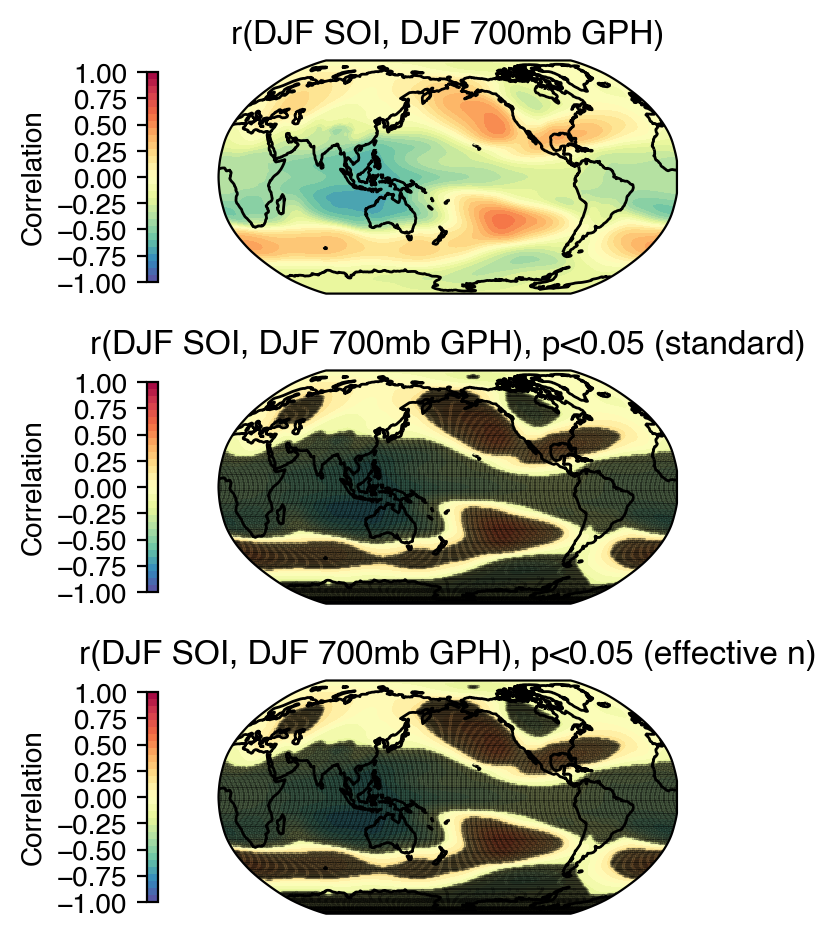

In [13]:
# significance masks for the two different p-value approaches
lons, lats = np.meshgrid(pearson_field.lon, pearson_field.lat)
sig_area_std = np.where(pvalue_field.values     < 0.05)
sig_area_eff = np.where(pvalue_eff_field.values < 0.05)

# This time we'll make 3 panels and show the two different p-value methods
fig, (ax1, ax2, ax3) = plt.subplots(
    clear=True, nrows=3, ncols=1,
    subplot_kw={'projection': ccrs.Robinson(central_longitude=180)}
)

levels = np.linspace(-1, 1, 31)

fx1 = ax1.contourf(pearson_field.lon, pearson_field.lat, pearson_field, levels=levels, cmap='Spectral_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax1.coastlines(color='black')
ax1.set_title('r(DJF SOI, DJF 700mb GPH)', fontsize=12)
cb1 = plt.colorbar(fx1, orientation='vertical', location='left', shrink=0.9, pad=0.05, ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb1.set_label('Correlation', fontsize=10)

fx2 = ax2.contourf(pearson_field.lon, pearson_field.lat, pearson_field,levels=levels, cmap='Spectral_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax2.coastlines(color='black')
ax2.set_title('r(DJF SOI, DJF 700mb GPH), p<0.05 (standard)', fontsize=12)
cb2 = plt.colorbar(fx2, orientation='vertical', location='left', shrink=0.9, pad=0.05, ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb2.set_label('Correlation', fontsize=10)
ax2.scatter(lons[sig_area_std], lats[sig_area_std], marker='.', s=0.1, c='k', alpha=0.5, transform=ccrs.PlateCarree())

fx3 = ax3.contourf(pearson_field.lon, pearson_field.lat, pearson_field, levels=levels, cmap='Spectral_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax3.coastlines(color='black')
ax3.set_title('r(DJF SOI, DJF 700mb GPH), p<0.05 (effective n)', fontsize=12)
cb3 = plt.colorbar(fx3, orientation='vertical', location='left', shrink=0.9, pad=0.05, ticks=[-1, -0.75, -0.50, -0.25, 0.0, 0.25, 0.50, 0.75, 1])
cb3.set_label('Correlation', fontsize=10)
ax3.scatter(lons[sig_area_eff], lats[sig_area_eff], marker='.', s=0.1, c='k', alpha=0.5, transform=ccrs.PlateCarree())

plt.tight_layout()